## Setup and Data Loading

In [1]:
import polars as pl
import numpy as np
import joblib
import pandas as pd
import json
import matplotlib.pyplot as plt
from pathlib import Path
pd.options.display.float_format = '{:,.2f}'.format

# Paths
MODEL_PATH = Path("../artifacts/models/xgb_v1.joblib")
DATA_PATH = Path("../data/processed/paysim_features_v1_1.parquet")
TEST_START_DAY = 26
OUT_DIR = Path("../artifacts/metrics")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# --- Business Assumptions ---
# 1. Margin: We make a 2% fee on good transactions.
# 2. Fraud Loss: We lose 100% of the transaction amount if fraud succeeds.
# 3. Operational Cost: It costs 5 local currency units in support/review time every time we block a transaction (False Positive).

MARGIN_RATE = 0.02
REVIEW_COST = 5.0
USE_TRANSACTION_AMOUNTS = True # if False, use avg_fraud_loss * fraud_multiplier
AVG_FRAUD_LOSS = None # will be computed from test set if None
FRAUD_MULTIPLIER = 1.5 # multiplier for chargeback/ops overhead when using proxy

results = []
thresholds = np.linspace(0.01, 0.99, 99)

print("Loading model and test data...")
bundle = joblib.load(MODEL_PATH)
model = bundle["model"]
feature_cols = bundle["features"]

df_test = pl.scan_parquet(DATA_PATH).filter(pl.col("day") >= TEST_START_DAY).collect()
X_test = df_test.select(feature_cols).to_numpy()
y_test = df_test.select("isFraud").to_numpy().ravel()
amounts = df_test.select("amount").to_numpy().ravel()

# Compute fallback avg fraud loss if needed
if AVG_FRAUD_LOSS is None: 
    fraud_amounts = amounts[y_test == 1] 
    AVG_FRAUD_LOSS = float(np.mean(fraud_amounts)) if len(fraud_amounts) > 0 else 0.0 
print(f"Test transactions: {len(y_test):,}, avg fraud amount (test): ${AVG_FRAUD_LOSS:,.2f}")

# Generate Probabilities
print("Scoring test transactions...")
y_probs = model.predict_proba(X_test)[:, 1]
results = []
print(f"Scored {len(y_probs):,} transactions.")

Loading model and test data...
Test transactions: 89,698, avg fraud amount (test): $1,711,368.04
Scoring test transactions...
Scored 89,698 transactions.


## Simulating Business Economics

In [9]:
# for thresh in thresholds:
#     # Simulate blocking decisions
#     preds = (y_probs >= thresh).astype(int)
    
#     # Outcomes
#     true_positives = (preds == 1) & (y_test == 1) # Fraud stopped
#     false_positives = (preds == 1) & (y_test == 0) # Good user blocked
#     false_negatives = (preds == 0) & (y_test == 1) # Fraud missed
#     true_negatives = (preds == 0) & (y_test == 0) # Good user approved
    
#     # Financial Impact
#     revenue_kept = np.sum(amounts[true_negatives]) * MARGIN_RATE
#     fraud_losses = np.sum(amounts[false_negatives])
#     fp_penalties = np.sum(false_positives) * REVIEW_COST
    
#     net_profit = revenue_kept - fraud_losses - fp_penalties
    
#     # Operational Metrics
#     approval_rate = (np.sum(preds == 0) / len(y_test)) * 100
#     recall = (np.sum(true_positives) / np.sum(y_test)) * 100 if np.sum(y_test) > 0 else 0
#     precision = (np.sum(true_positives) / np.sum(preds)) * 100 if np.sum(preds) > 0 else 0
    
#     results.append({
#         "Threshold": thresh,
#         "Net Profit (local currency units)": net_profit,
#         "Approval Rate (%)": approval_rate,
#         "Fraud Caught (%)": recall,
#         "Precision (%)": precision,
#         "Good Users Blocked": np.sum(false_positives)
#     })

# df_results = pd.DataFrame(results)

# # Find the threshold that maximizes profit
# optimal_row = df_results.loc[df_results["Net Profit (local currency units)"].idxmax()]
# print("=== OPTIMAL BUSINESS THRESHOLD ===")
# print(optimal_row)

### Economic Interpretation

All monetary values are expressed in **unspecified local currency units** as provided by the PaySim dataset.
No conversion to USD, GBP, or EUR is performed.

The objective is to **maximize relative net value across thresholds**, not to estimate absolute profit in a real-world currency.


In [2]:
# Threshold sweep computing both transaction-level and proxy net values
for thresh in thresholds:
    preds = (y_probs >= thresh).astype(int)

    true_positives = (preds == 1) & (y_test == 1)  # fraud stopped
    false_positives = (preds == 1) & (y_test == 0) # good user blocked
    false_negatives = (preds == 0) & (y_test == 1) # fraud missed
    true_negatives = (preds == 0) & (y_test == 0)  # good user approved

    # Transaction-level economics (granular)
    revenue_kept_tx = np.sum(amounts[true_negatives]) * MARGIN_RATE
    fraud_losses_tx = np.sum(amounts[false_negatives])  # full amount lost on missed fraud
    fp_penalties = np.sum(false_positives) * REVIEW_COST
    net_profit_tx = revenue_kept_tx - fraud_losses_tx - fp_penalties

    # Proxy economics (avg_fraud_loss * fraud_multiplier)
    revenue_kept_proxy = np.sum(true_negatives) * AVG_FRAUD_LOSS * FRAUD_MULTIPLIER * MARGIN_RATE
    fraud_losses_proxy = np.sum(false_negatives) * AVG_FRAUD_LOSS * FRAUD_MULTIPLIER
    net_profit_proxy = revenue_kept_proxy - fraud_losses_proxy - fp_penalties

    # Operational metrics
    approval_rate = (np.sum(preds == 0) / len(y_test)) * 100
    recall = (np.sum(true_positives) / np.sum(y_test)) * 100 if np.sum(y_test) > 0 else 0
    precision = (np.sum(true_positives) / np.sum(preds)) * 100 if np.sum(preds) > 0 else 0

    results.append({
        "threshold": float(thresh),
        "net_profit_tx": float(net_profit_tx),
        "net_profit_proxy": float(net_profit_proxy),
        "revenue_kept_tx": float(revenue_kept_tx),
        "fraud_losses_tx": float(fraud_losses_tx),
        "revenue_kept_proxy": float(revenue_kept_proxy),
        "fraud_losses_proxy": float(fraud_losses_proxy),
        "fp_penalties": float(fp_penalties),
        "approval_rate_pct": float(approval_rate),
        "fraud_caught_pct": float(recall),
        "precision_pct": float(precision),
        "good_users_blocked": int(np.sum(false_positives))
    })

df_results = pd.DataFrame(results)
df_results.to_csv(OUT_DIR / "econ_threshold_sweep_v1.csv", index=False)

assumptions = {
    "MARGIN_RATE": MARGIN_RATE,
    "REVIEW_COST": REVIEW_COST,
    "USE_TRANSACTION_AMOUNTS": USE_TRANSACTION_AMOUNTS,
    "AVG_FRAUD_LOSS": AVG_FRAUD_LOSS,
    "FRAUD_MULTIPLIER": FRAUD_MULTIPLIER,
    "model_artifact": str(MODEL_PATH),
    "feature_set": feature_cols,
    "test_window": "day >= 26",
    "num_test_transactions": int(len(y_test))
}
with open(OUT_DIR / "econ_assumptions_v1.json", "w") as f:
    json.dump(assumptions, f, indent=2)

print("Saved econ sweep CSV and assumptions JSON to artifacts/metrics")

Saved econ sweep CSV and assumptions JSON to artifacts/metrics


In [6]:
# Identify optimal threshold using transaction-level net value
optimal_idx = df_results["net_profit_tx"].idxmax()
optimal_row = df_results.loc[optimal_idx]

print("=== OPTIMAL BUSINESS THRESHOLD ===")
print(f"Threshold:                 {optimal_row['threshold']:.2f}")
print(f"Net Value (units):         {optimal_row['net_profit_tx']:,.2f}")
print(f"Approval Rate (%):         {optimal_row['approval_rate_pct']:.2f}")
print(f"Fraud Caught (%):          {optimal_row['fraud_caught_pct']:.2f}")
print(f"Precision (%):             {optimal_row['precision_pct']:.2f}")
print(f"Good Users Blocked:        {int(optimal_row['good_users_blocked']):,}")

=== OPTIMAL BUSINESS THRESHOLD ===
Threshold:                 0.09
Net Value (units):         131,053,571.49
Approval Rate (%):         89.79
Fraud Caught (%):          81.46
Precision (%):             11.90
Good Users Blocked:        8,070


## Visualizing the Trade-off

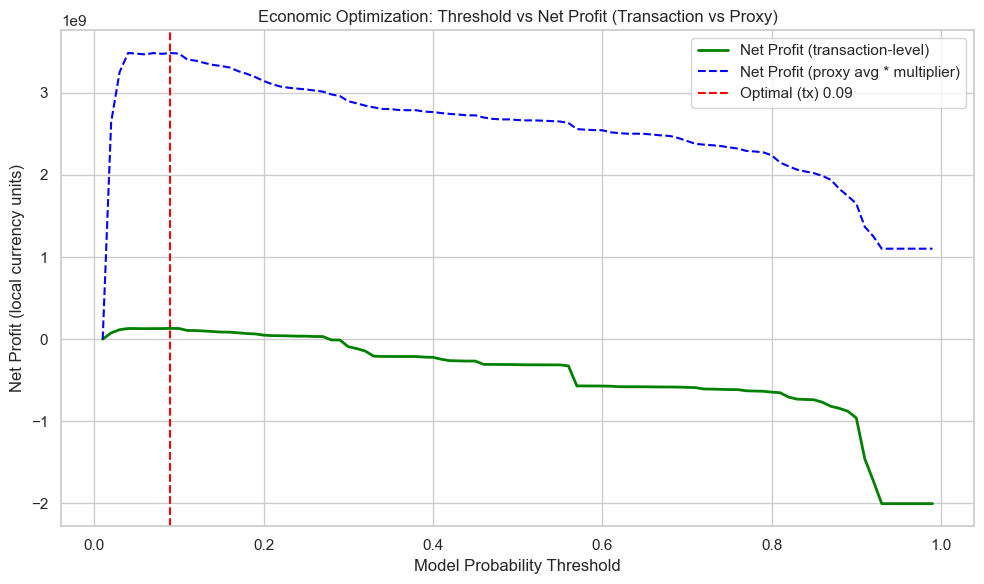

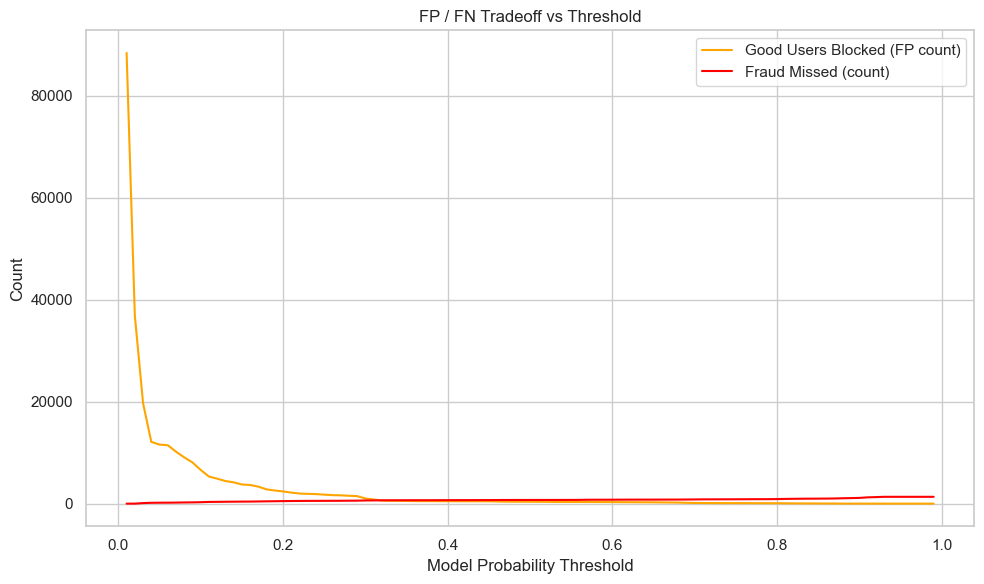

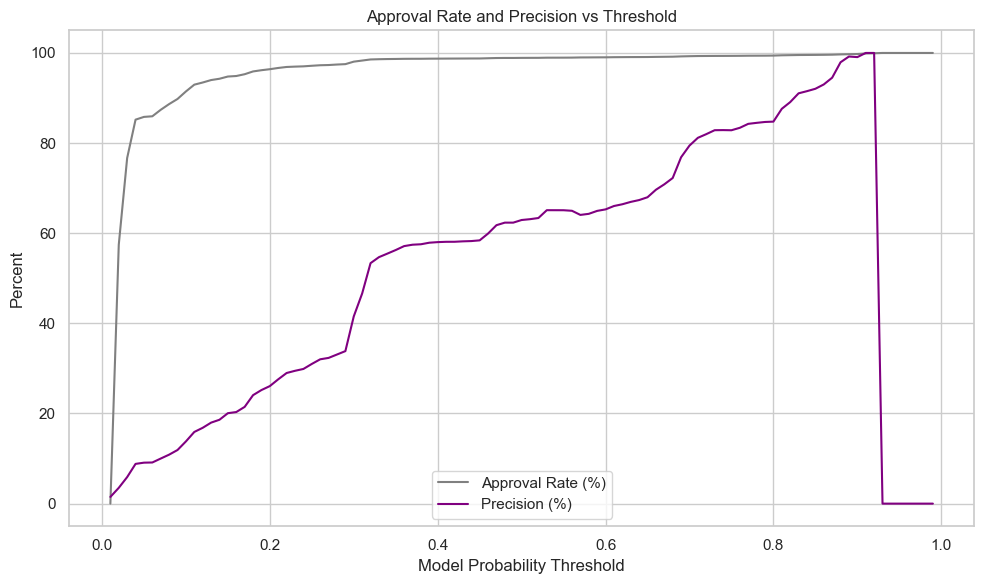

Saved plots and top-5 optimal threshold tables to artifacts/metrics


In [3]:
# Sensitivity analysis and plots
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", rc={"figure.figsize": (10, 6)})

# Load results (if running in a fresh kernel)
# df_results = pd.read_csv(OUT_DIR / "econ_threshold_sweep_v1.csv")

# Plot 1: Transaction-level vs Proxy net profit
plt.plot(df_results["threshold"], df_results["net_profit_tx"], label="Net Profit (transaction-level)", color="green", linewidth=2)
plt.plot(df_results["threshold"], df_results["net_profit_proxy"], label="Net Profit (proxy avg * multiplier)", color="blue", linestyle="--")
plt.axvline(x=df_results["threshold"].iloc[df_results["net_profit_tx"].idxmax()], color='red', linestyle='--', label=f'Optimal (tx) {df_results["threshold"].iloc[df_results["net_profit_tx"].idxmax()]:.2f}')
plt.title("Economic Optimization: Threshold vs Net Profit (Transaction vs Proxy)")
plt.xlabel("Model Probability Threshold")
plt.ylabel("Net Profit (local currency units)")
plt.legend()
plt.tight_layout()
plt.savefig(OUT_DIR / "net_profit_comparison.png")
plt.show()

# Plot 2: FP / FN tradeoff (Good users blocked vs Fraud missed)
plt.figure(figsize=(10,6))
plt.plot(df_results["threshold"], df_results["good_users_blocked"], label="Good Users Blocked (FP count)", color="orange")
# Fraud missed = total frauds - fraud caught
total_frauds = np.sum(y_test)
fraud_missed = total_frauds - (df_results["fraud_caught_pct"] / 100.0 * total_frauds)
plt.plot(df_results["threshold"], fraud_missed, label="Fraud Missed (count)", color="red")
plt.title("FP / FN Tradeoff vs Threshold")
plt.xlabel("Model Probability Threshold")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.savefig(OUT_DIR / "fp_fn_tradeoff.png")
plt.show()

# Plot 3: Approval rate and precision vs threshold
plt.figure(figsize=(10,6))
plt.plot(df_results["threshold"], df_results["approval_rate_pct"], label="Approval Rate (%)", color="gray")
plt.plot(df_results["threshold"], df_results["precision_pct"], label="Precision (%)", color="purple")
plt.title("Approval Rate and Precision vs Threshold")
plt.xlabel("Model Probability Threshold")
plt.ylabel("Percent")
plt.legend()
plt.tight_layout()
plt.savefig(OUT_DIR / "approval_precision_vs_threshold.png")
plt.show()

# Save top 5 optimal thresholds for both metrics
top_tx = df_results.sort_values(by="net_profit_tx", ascending=False).head(5)
top_proxy = df_results.sort_values(by="net_profit_proxy", ascending=False).head(5)
top_tx.to_csv(OUT_DIR / "top5_optimal_thresholds_tx.csv", index=False)
top_proxy.to_csv(OUT_DIR / "top5_optimal_thresholds_proxy.csv", index=False)

print("Saved plots and top-5 optimal threshold tables to artifacts/metrics")


In [7]:
# Display top 5 thresholds by transaction-level net value
top5 = (
    df_results
    .sort_values(by="net_profit_tx", ascending=False)
    .head(5)
    .loc[:, [
        "threshold",
        "net_profit_tx",
        "approval_rate_pct",
        "fraud_caught_pct",
        "precision_pct",
        "good_users_blocked"
    ]]
)

top5.rename(columns={
    "threshold": "Threshold",
    "net_profit_tx": "Net Value (local currency units)",
    "approval_rate_pct": "Approval Rate (%)",
    "fraud_caught_pct": "Fraud Caught (%)",
    "precision_pct": "Precision (%)",
    "good_users_blocked": "Good Users Blocked"
})

top5

,threshold,net_profit_tx,approval_rate_pct,fraud_caught_pct,precision_pct,good_users_blocked
8,0.09,"131,053,571.49",89.79,81.46,11.90,8070
9,0.10,"129,535,005.51",91.46,79.07,13.80,6606
3,0.04,"129,495,431.03",85.20,87.52,8.82,12105
4,0.05,"128,847,964.56",85.81,86.47,9.09,11571
7,0.08,"128,698,785.60",88.66,82.66,10.87,9070


In [8]:
# plt.figure(figsize=(12, 6))

# # Plot Net Profit curve
# plt.plot(df_results["Threshold"], df_results["Net Profit (local currency units)"], label="Net Profit (local currency units)", color="green", linewidth=2)

# # Highlight the optimal point
# plt.axvline(x=optimal_row["Threshold"], color='red', linestyle='--', label=f'Optimal Thresh: {optimal_row["Threshold"]:.2f}')

# plt.title("Economic Optimization: Threshold vs. Net Profit")
# plt.xlabel("Model Probability Threshold")
# plt.ylabel("Net Profit (local currency units)")
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.show()

# # Show the top 5 most profitable thresholds
# df_results.sort_values(by="Net Profit (local currency units)", ascending=False).head(5)